In [47]:
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
import time

import tensorflow as tf

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

In [48]:
tf.compat.v1.enable_eager_execution()
print("Eager execution enabled: {}".format(tf.executing_eagerly()))

Eager execution enabled: True


In [49]:
content_path = 'images/content/new_york.jpg'
style_path = 'images/style/leonid_afremov.jpg'

mean_values = np.array([123.68, 116.779, 103.939])

In [109]:
def load_and_process_image(path_to_image):
    img = Image.open(path_to_image)
    img = img.resize((512, 512), Image.ANTIALIAS)
    # preprocessing step
    img = img - mean_values
    # expanding dim so that the image becomes (1, nH, nW, nC)
    img = np.expand_dims(img, axis=0)
    return img

def deprocess_image(img):
    out = img.copy()
    out = np.squeeze(out, axis = 0)
    out[:,:,0] += 123.68
    out[:,:,1] += 116.779
    out[:,:,2] += 103.939
    out = np.clip(out, 0, 255).astype('uint8')
    plt.imshow(out)
    return out


In [110]:
content_layers = ['block5_conv2']
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]

num_style_layers = len(style_layers)
num_content_layers = len(content_layers)

In [111]:
def get_model():
    vgg = tf.keras.applications.vgg19.VGG19(include_top = False, weights = 'imagenet')
    vgg.trainable = False
    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    model_outputs = style_outputs + content_outputs
    return models.Model(vgg.input, model_outputs)

In [112]:
# m = get_model()
# m.summary()

In [113]:
def get_content_loss(base_content, target_content):
    return tf.reduce_mean(tf.square(base_content - target_content))

In [157]:
def gram_matrix(input_tensor):
    # Input tensor is of dims nH * nW * nC and dims of gram matrix is nC * nC
    # We make the image channels first 
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True) # (n_C *(n_H*n_W)) * ((n_H*n_W) * n_C) = (n_C * n_C)
    return gram / tf.cast(n, tf.float32)

def get_style_loss(gram_base_style, target_style):
    gram_target = gram_matrix(target_style)
    
    return tf.reduce_mean(tf.square(gram_base_style - gram_target))

In [158]:
def get_features(mode, content_path, style_path):
    
    content_image = load_and_process_image(content_path)
    style_image = load_and_process_image(style_path)
    
    content_outputs = model(content_image)
    style_outputs = model(style_image)
    
    style_features = [style_output[0] for style_output in style_outputs[:num_style_layers]]
    content_features = [content_output[0] for content_output in content_outputs[num_style_layers:]]
    
    return style_features, content_features

In [181]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    
    style_weight, content_weight = loss_weights
    
    model_outputs = model(init_image)
    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]
    
    style_loss = 0
    content_loss = 0
    # customs weights for each layer
    w = [0.5, 1.0, 1.5, 2.5, 4.0]
    ind = 0
    weight_per_style_layer = 1 / float(num_style_layers)
    for gram_style, target_style in zip(gram_style_features, style_output_features):
#         style_loss += weight_per_style_layer * get_style_loss(gram_style, target_style)
        style_loss += w[ind] * get_style_loss(gram_style, target_style)
        ind = ind + 1
        
    weight_per_content_layer = 1 / float(num_content_layers)
    for base_content, target_content in zip(content_features, content_output_features):
        content_loss += weight_per_content_layer * get_content_loss(base_content, target_content)
     
    style_loss *= style_weight
    content_loss *= content_weight
    
    total_loss = style_loss + content_loss
    
    return total_loss, style_loss, content_loss


In [182]:
def compute_grads(cfg):
    with tf.GradientTape() as tape:
        all_loss = compute_loss(**cfg)
  # Compute gradients wrt input image
    total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg['init_image']), all_loss

In [183]:
import IPython.display

def run_style_transfer(content_path, style_path, num_iterations = 1000, content_weight=1e3, style_weight=1e-2):
    
    model = get_model()
    for layer in model.layers:
        layer.trainable = False
       
    style_features, content_features = get_features(model, content_path, style_path)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
    
    init_image = load_and_process_image(content_path)
    init_image = tf.Variable(init_image, dtype = tf.float32)
    
    opt = tf.compat.v1.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)
    
    
    loss_weights = (style_weight, content_weight)
    cfg = {
          'model': model,
          'loss_weights': loss_weights,
          'init_image': init_image,
          'gram_style_features': gram_style_features,
          'content_features': content_features
    }
    
    min_vals = -mean_values
    max_vals = 255 - mean_values
    
    for i in range(num_iterations):
        grads, all_loss = compute_grads(cfg)
        loss, style_score, content_score = all_loss
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(clipped)
        
        if i % 2 == 0:
            plot_img = init_image.numpy()
            plot_img = deprocess_image(plot_img)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_img))
            print('Iteration: {}'.format(i)) 
            

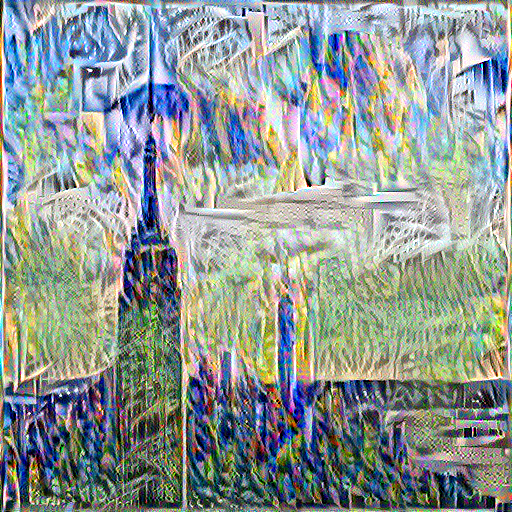

Iteration: 338


KeyboardInterrupt: 

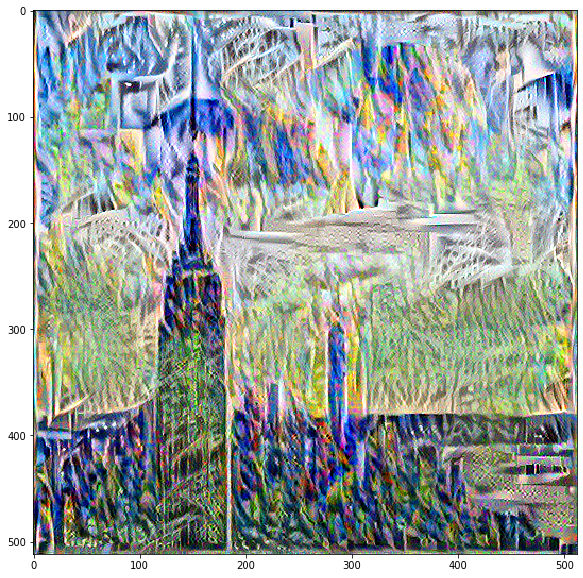

In [184]:
content_path = 'images/content/new_york.jpg'
style_path = 'images/style/style.jpg'
run_style_transfer(content_path, style_path, num_iterations = 1000)